# <center>WSB Posts Sentiment Analysis</center><br>
<img src = "https://i.insider.com/5dfb7ebf855cc232fc6669ac?width=700"></img><br>
#### <div align='right'>Done by: **Asad Mahmood</div>**

In [1]:
import numpy as np
import pandas as pd 
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy as sp
nlps = sp.load('en_core_web_sm')
import random
plt.rc('figure',figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to C:\Users\Asad
[nltk_data]     Mahmood\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<a id="toc"></a>

<div class="list-group" id="list-tab" role="tablist">
<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Table of Contents</center></h2>

1. [Introduction](#Intro)
2. [Objective](#Obj)
3. [Understanding Data](#EDA)
    1. Text Preprocessing
3. [Feature Engineering](#Fea)
    1. Sentiment Analysis
    2. Naive Feature Extraction
    3. Named Entity Extraction
4. [Title Text Sentiment Analysis](#TitleTextAnalysis)
5. [Title Time Based Sentiment Analysis](#TitleTimeAnalysis)
6. [Title Text Decomposition Analysis](#TitleDecomp)
7. [Body Text Sentiment Analysis](#BodyText)
8. [Body Time Based Sentiment Analysis](#BodyTime)
9. [Body Text Decomposition Analysis](#BodyTextDecomp)
6. [Conclusion](#Con)

<a name="Intro"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Introduction</center></h3>


WallStreetBets (r/wallstreetbets, also known as WSB), is a subreddit where participants discuss stock and option trading. It has become notable for its profane nature and allegations of users manipulating securities. Recently the community became mainstream again with its interest on GameStop shares.

The data might contain a small percent of harsh language, the posts were not filtered.

Reddit posts from subreddit WallStreetBets, downloaded from https://www.reddit.com/r/wallstreetbets/ using praw (The Python Reddit API Wrapper).

<a name="Obj"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Objective</center></h3>

The purpose of this project is to use WSB Reddit posts data to understand the discussion trends in the community and analyze the general sentiment of the posts.

<a name="EDA"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Understanding Data</center></h3>

In [2]:
r_data = pd.read_csv('reddit_wsb.csv')
r_data.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  
0                                                NaN  2021-01-28 21:37:41  
1                                                NaN  2021-01-28 21:32:10  
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35  
3                                                NaN  2021-01-28 21:28:57  
4                                                NaN  2021-01-28 21:26:56

<div class="list-group" id="list-tab" role="tablist">
<h4 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gray; border:0' role="tab" aria-controls="home"><center>Text Preprocessing</center></h4>

In [3]:
#Seperating titles and body text into separate dataframes
title_data = r_data[['title','timestamp']].copy()
body_data = r_data[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()

#Making everything lowercase
title_data.title =title_data.title.str.lower()
body_data.body =body_data.body.str.lower()

#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#Remove Time From Timestamp
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

Giving the text a makeover and removing unnecessary details.

<a name="Fea"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Feature Engineering</center></h3>

<a id="2"></a>

<div class="list-group" id="list-tab" role="tablist">
<h4 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gray; border:0' role="tab" aria-controls="home"><center>Sentiment Analysis</center></h4>

In [4]:
sid = SIA()
body_data['sentiments']           = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

body_data.drop(columns=['sentiments'],inplace=True)


title_data['sentiments']           = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment']   = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment']    = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment']   = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)

<a id="2"></a>

<div class="list-group" id="list-tab" role="tablist">
<h4 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gray; border:0' role="tab" aria-controls="home"><center>Naive Feature Extraction</center></h4>

In [5]:
body_data['# Of Words']          = body_data['body'].apply(lambda x: len(x.split(' ')))
body_data['# Of StopWords']      = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
body_data['Average Word Length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

title_data['# Of Words']          = title_data['title'].apply(lambda x: len(x.split(' ')))
title_data['# Of StopWords']      = title_data['title'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
title_data['Average Word Length'] = title_data['title'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.



<a id="2"></a>

<div class="list-group" id="list-tab" role="tablist">
<h4 class="list-group-item list-group-item-action active" data-toggle="list" style='background:gray; border:0' role="tab" aria-controls="home"><center>Named Entity Extraction</center></h4>

In [6]:
title_data['# Of Times Currency Was Mentioned']      = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
title_data['# Of Organizations Mentioned']           = title_data['title'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))

print('Processed Title DataFrame')
body_data['# Of Times Currency Was Mentioned']      = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'MONEY' ]))
body_data['# Of Organizations Mentioned']           = body_data['body'].apply(lambda x: len([tok for tok in nlps(x).ents if tok.label_ == 'ORG' ]))
print('Processed Body DataFrame')


Processed Title DataFrame
Processed Body DataFrame


<a name="TitleTextAnalysis"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Title Text Sentiment Analysis</center></h3>

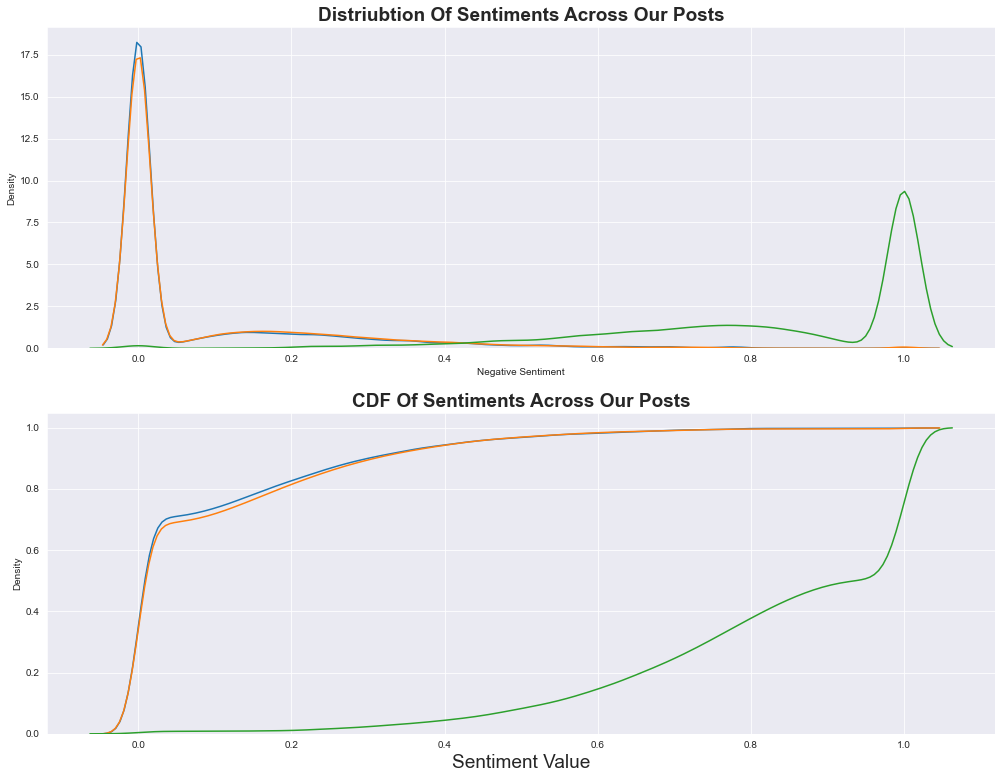

In [7]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(title_data['Negative Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Positive Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(title_data['Neutral Sentiment'],bw_method=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

**Observation**: Apparently, The dominant sentiment among the Reddit post titles is by far neutral. Even more, there is a probability of 60% that a post title is classified to be completely neutral.

<a name="TitleTimeAnalysis"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Title Time Based Sentiment Analysis</center></h3>

In [8]:
#Sorting And Feature Engineering
f_data = title_data.sort_values(by='timestamp')
ft_data=f_data.copy()
ft_data = ft_data.rename(columns={'timestamp':'date'})
ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1


In [9]:
f_data=f_data.reset_index().drop(columns=['index'])
f_data = f_data.rename(columns={'timestamp':'date'})

partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])



neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)

**Observation:** The mean between our consecutive partitions is quite similar; there is a chance of the sentiment data being stationary over time; thus, we will continue exploring the sentiments' stationarity.

In [10]:
fig = make_subplots(rows=3, cols=2)

for idx,prt in enumerate(partitions):
    by_date = prt.groupby(by='date').mean().reset_index()
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Positive Sentiment'],name=f'Positive Part {idx+1}'),
    row=idx+1, col=1)
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Negative Sentiment'],name=f'Negative Part {idx+1}'),
    row=idx+1, col=2)

fig.update_layout(height=600, width=900, title_text="Distibution Of Daily Mean Sentiments Over Our Time Line For Each Partition")
fig.show()

In [11]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()

**Observation**: Due to the visible trend both in the positive and negative sentiments of the post titles, we can conclude that the data is not stationary.

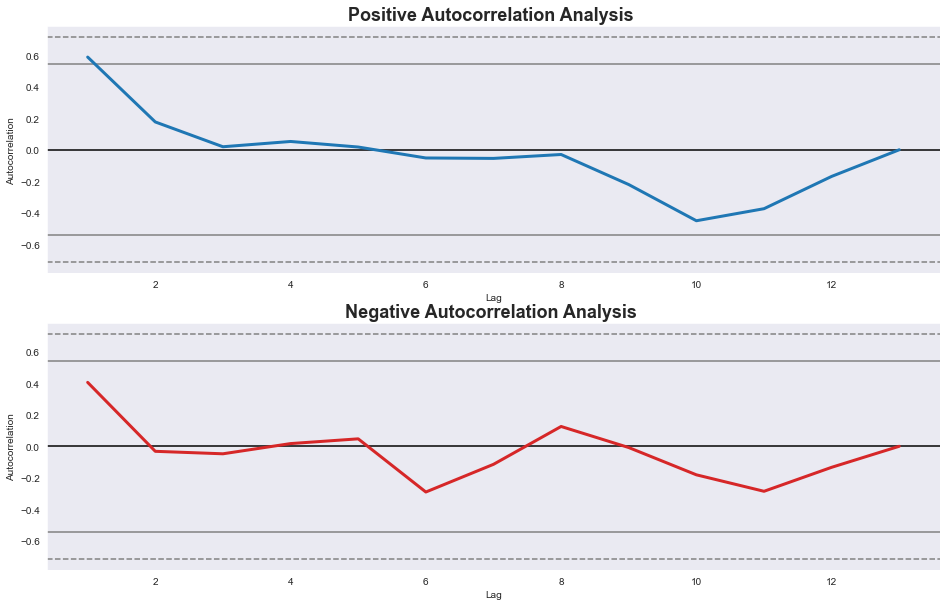

In [12]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()

**Observation**: As for autocorrelation between time lags, we see that there is no lag correlation of which is beyond our significance threshold.

In [13]:
b_date_mean = ft_data.groupby(by='date').mean().reset_index()
b_date_std = ft_data.groupby(by='date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)




fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

**Observation**: It can be observed that with time the average negative sentiment is following a decreasing trend as the average  positive sentiment keeps increasing over time 

In [14]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Deviation in Positive Sentiment',  'Daily Deviation in Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_std['date'], y=b_date_std['Positive Sentiment'],name='Positive Sentiment SD'),
    row=1, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['date'].values[0], y0=b_date_std['Negative Sentiment'].mean(), x1=b_date_std['date'].values[-1], y1=b_date_std['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['date'].values[0], y0=b_date_std['Positive Sentiment'].mean(), x1=b_date_std['date'].values[-1], y1=b_date_std['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x1', 
        yref='y1'
)


fig.add_trace(
    go.Scatter(x=b_date_std['date'], y=b_date_std['Negative Sentiment'],name='Negative Sentiment SD'),
    row=2, col=1
)

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Deviation Change With Time")
fig.show()

In [15]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()

In [16]:
b_date_count = ft_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'title':'Posts Per Day'})
fig = ex.line(b_date_count,x='date',y='Posts Per Day')


fig.add_shape(type="line",
    x0=b_date_count['date'].values[0], y0=b_date_count['Negative Sentiment'].mean(), x1=b_date_count['date'].values[-1], y1=b_date_count['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
)

fig.update_traces(mode="markers+lines")
fig.update_layout(hovermode="x unified")


fig.update_layout(title='<b>Daily Post Count<b>')
fig.show()

**Observation**: Assuming that Jan 29th has a higher amount of posts is due to the dataset author extraction decision, we see that the daily amount of posts is fairly stable around a mean value of 2020 posts per day.

<a name="TitleDecomp"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Title Text Decomposition Analysis</center></h3>

In [17]:
nltk.download('punkt')
nltk.download('wordnet')
NUMBER_OF_COMPONENTS = 450

CVZ = CountVectorizer()
SVD = TruncatedSVD(NUMBER_OF_COMPONENTS)

text_data = f_data.title.copy()
text_data = text_data.apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS and len(word) > 1]).strip())

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

text_data = text_data.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
text_data = text_data.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

C_vector = CVZ.fit_transform(text_data)


pc_matrix = SVD.fit_transform(C_vector)

evr = SVD.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar", 
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(     title='{:.2f}% of the Post Text Variance Can Be Explained Using {} Words'.format(np.sum(evr)*100,NUMBER_OF_COMPONENTS))
fig.show()

[nltk_data] Downloading package punkt to C:\Users\Asad
[nltk_data]     Mahmood\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asad
[nltk_data]     Mahmood\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


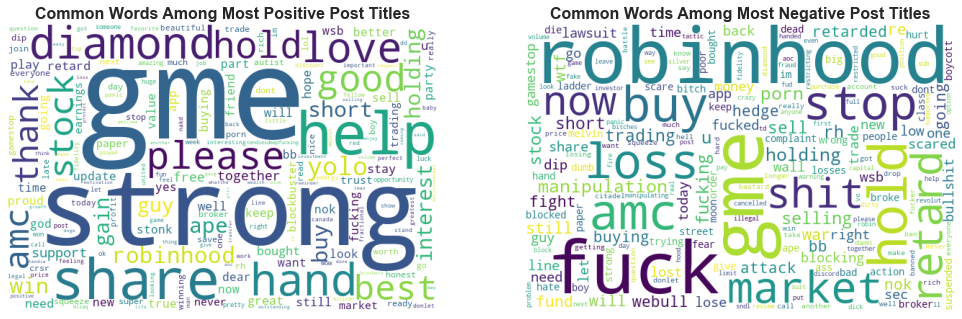

In [18]:
Most_Positive = title_data[title_data['Positive Sentiment'].between(0.4,1)]['title']
Most_Negative = title_data[title_data['Negative Sentiment'].between(0.25,1)]['title']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Post Titles',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Post Titles',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

<a name="BodyText"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Body Text Sentiment Analysis</center></h3>

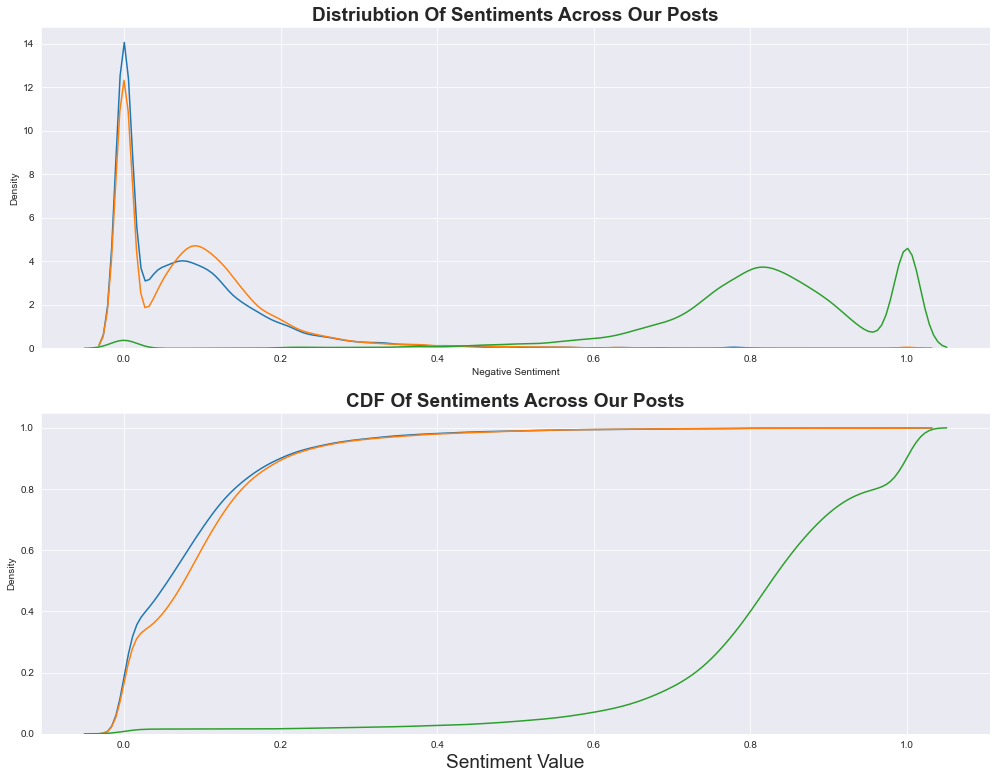

In [19]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(body_data['Negative Sentiment'],bw_method=0.1)
sns.kdeplot(body_data['Positive Sentiment'],bw_method=0.1)
sns.kdeplot(body_data['Neutral Sentiment'],bw_method=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Posts',fontsize=19,fontweight='bold')
sns.kdeplot(body_data['Negative Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(body_data['Positive Sentiment'],bw_method=0.1,cumulative=True)
sns.kdeplot(body_data['Neutral Sentiment'],bw_method=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

**Observation**: An interesting observation can be made about the distribution of sentiments in the post's body; we can see a bimodal distribution at each of our sentiments, potentially pointing to 2 underlaying groups of posts in our data.

<a name="BodyTime"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Body Time Based Sentiment Analysis</center></h3>

In [20]:
#Sorting And Feature Engineering
f_data = body_data.sort_values(by='timestamp')
ft_data=f_data.copy()
ft_data = ft_data.rename(columns={'timestamp':'date'})
ft_data['year']         = pd.DatetimeIndex(ft_data['date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1


In [21]:
f_data=f_data.reset_index().drop(columns=['index'])
f_data = f_data.rename(columns={'timestamp':'date'})

partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])



neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)

**Observation:** The mean between our consecutive partitions is quite similar; there is a chance of the sentiment data being stationary over time; thus, we will continue exploring the sentiments' stationarity.

In [22]:
fig = make_subplots(rows=3, cols=2)

for idx,prt in enumerate(partitions):
    by_date = prt.groupby(by='date').mean().reset_index()
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Positive Sentiment'],name=f'Positive Part {idx+1}'),
    row=idx+1, col=1)
    fig.add_trace(
    go.Scatter(x=by_date['date'], y=by_date['Negative Sentiment'],name=f'Negative Part {idx+1}'),
    row=idx+1, col=2)

fig.update_layout(height=600, width=900, title_text="Distibution Of Daily Mean Sentiments Over Our Time Line For Each Partition")
fig.show()

In [23]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()

**Observation**: Due to the visible trend both in the positive and negative sentiments of the post titles, we can conclude that the data is not stationary.

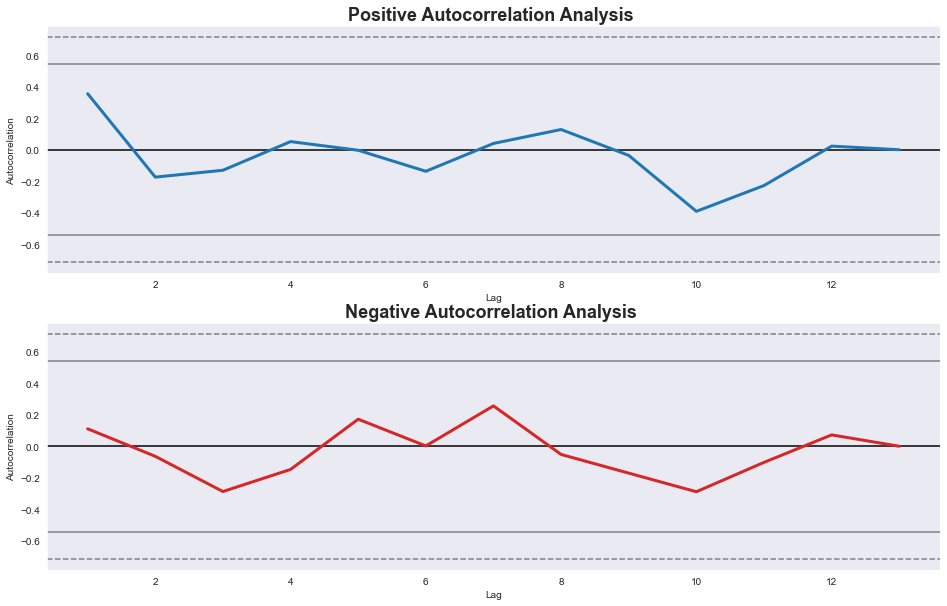

In [24]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()

**Observation**: As for autocorrelation between time lags, we see that there is no lag correlation of which is beyond our significance threshold.

In [25]:
b_date_mean = ft_data.groupby(by='date').mean().reset_index()
b_date_std = ft_data.groupby(by='date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)




fig.add_trace(
    go.Scatter(x=b_date_mean['date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

In [26]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Deviation in Positive Sentiment',  'Daily Deviation in Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_std['date'], y=b_date_std['Positive Sentiment'],name='Positive Sentiment SD'),
    row=1, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['date'].values[0], y0=b_date_std['Negative Sentiment'].mean(), x1=b_date_std['date'].values[-1], y1=b_date_std['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['date'].values[0], y0=b_date_std['Positive Sentiment'].mean(), x1=b_date_std['date'].values[-1], y1=b_date_std['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x1', 
        yref='y1'
)


fig.add_trace(
    go.Scatter(x=b_date_std['date'], y=b_date_std['Negative Sentiment'],name='Negative Sentiment SD'),
    row=2, col=1
)

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Deviation Change With Time")
fig.show()

In [27]:
by_date = title_data.groupby(by='timestamp').sum().reset_index()

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Number Of Times Currency Was Mentioned',
                                                                     'Daily Average Number Of Times Organizations Were Mentioned'))

fig.add_trace(
    go.Scatter(x=by_date['timestamp'], y=by_date['# Of Times Currency Was Mentioned'],name='Currency Mentioned'),
    row=1, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=by_date['timestamp'].values[0], y0=by_date['# Of Times Currency Was Mentioned'].mean(), x1=by_date['timestamp'].values[-1], y1=by_date['# Of Times Currency Was Mentioned'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x1', 
        yref='y1'
)

#negative mean
fig.add_shape(type="line",
    x0=by_date['timestamp'].values[0], y0=by_date['# Of Organizations Mentioned'].mean(), x1=by_date['timestamp'].values[-1], y1=by_date['# Of Organizations Mentioned'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig.add_trace(
    go.Scatter(x=by_date['timestamp'], y=by_date['# Of Organizations Mentioned'],name='Organizations Mentioned'),
    row=2, col=1
)

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="How much on average do different themes appear in post titles")
fig.show()

In [28]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Perason Correaltion',  'Spearman Correaltion'))
colorscale=     [[1.0              , "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0               , "rgb(49,54,149)"]]

s_val =f_data.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,name='pearson',showscale=False,xgap=1,ygap=1,colorscale=colorscale),
    row=1, col=1
)


s_val =f_data.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x=s_col,y=s_idx,z=s_val,xgap=1,ygap=1,colorscale=colorscale),
    row=2, col=1
)

fig.update_layout(height=700, width=900, title_text="Locations That Contribute The Most To Our Cut-Offs")
fig.show()

In [29]:
by_date = body_data.groupby(by='timestamp').sum().reset_index()

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Number Of Times Currency Was Mentioned',
                                                                     'Daily Average Number Of Times Organizations Were Mentioned'))

fig.add_trace(
    go.Scatter(x=by_date['timestamp'], y=by_date['# Of Times Currency Was Mentioned'],name='Currency Mentioned'),
    row=1, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=by_date['timestamp'].values[0], y0=by_date['# Of Times Currency Was Mentioned'].mean(), x1=by_date['timestamp'].values[-1], y1=by_date['# Of Times Currency Was Mentioned'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x1', 
        yref='y1'
)

#negative mean
fig.add_shape(type="line",
    x0=by_date['timestamp'].values[0], y0=by_date['# Of Organizations Mentioned'].mean(), x1=by_date['timestamp'].values[-1], y1=by_date['# Of Organizations Mentioned'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)


fig.add_trace(
    go.Scatter(x=by_date['timestamp'], y=by_date['# Of Organizations Mentioned'],name='Organizations Mentioned'),
    row=2, col=1
)

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="How much on average do different themes appear in post bodies")
fig.show()

<a name="BodyTextDecomp"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Body Text Decomposition Analysis</center></h3>

In [30]:
NUMBER_OF_COMPONENTS = 450

CVZ = CountVectorizer()
SVD = TruncatedSVD(NUMBER_OF_COMPONENTS)

text_data = f_data.body.copy()
text_data = text_data.apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS and len(word) > 1]).strip())

stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

text_data = text_data.apply(lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x)]))
text_data = text_data.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

C_vector = CVZ.fit_transform(text_data)


pc_matrix = SVD.fit_transform(C_vector)

evr = SVD.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance", 
    "type": "bar", 
    'y':evr}
trace2 = {
    "name": "cumulative explained variance", 
    "type": "scatter", 
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"}, 
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data=data, layout=layout)
fig.update_layout(     title='{:.2f}% of the Post Text Variance Can Be Explained Using {} Words'.format(np.sum(evr)*100,NUMBER_OF_COMPONENTS))
fig.show()

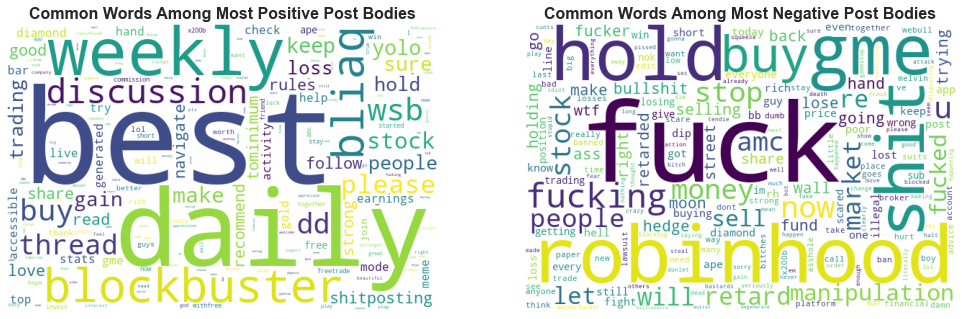

In [31]:
Most_Positive = body_data[body_data['Positive Sentiment'].between(0.4,1)]['body']
Most_Negative = body_data[body_data['Negative Sentiment'].between(0.25,1)]['body']

Most_Positive_text = ' '.join(Most_Positive)
Most_Negative_text = ' '.join(Most_Negative)


pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Post Bodies',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Post Bodies',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

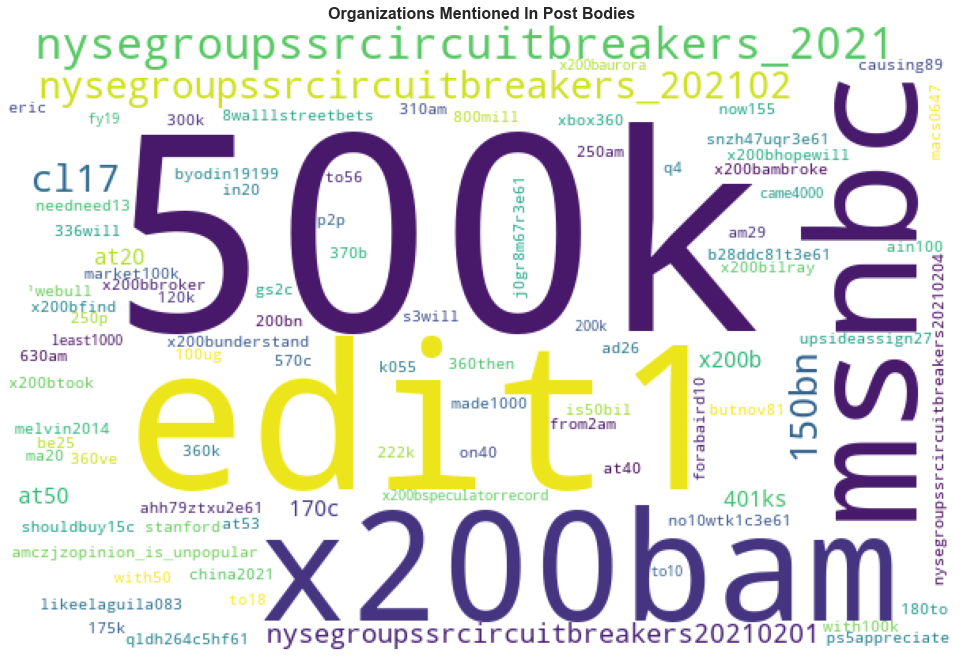

In [32]:
had_org = body_data[body_data['# Of Organizations Mentioned']>0].copy()
org_names = []
for body in had_org.body:
    org_names+=[str(tok) for tok in nlps(body).ents if tok.label_ == 'ORG' ]
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(' '.join(org_names))

plt.title('Organizations Mentioned In Post Bodies',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()    

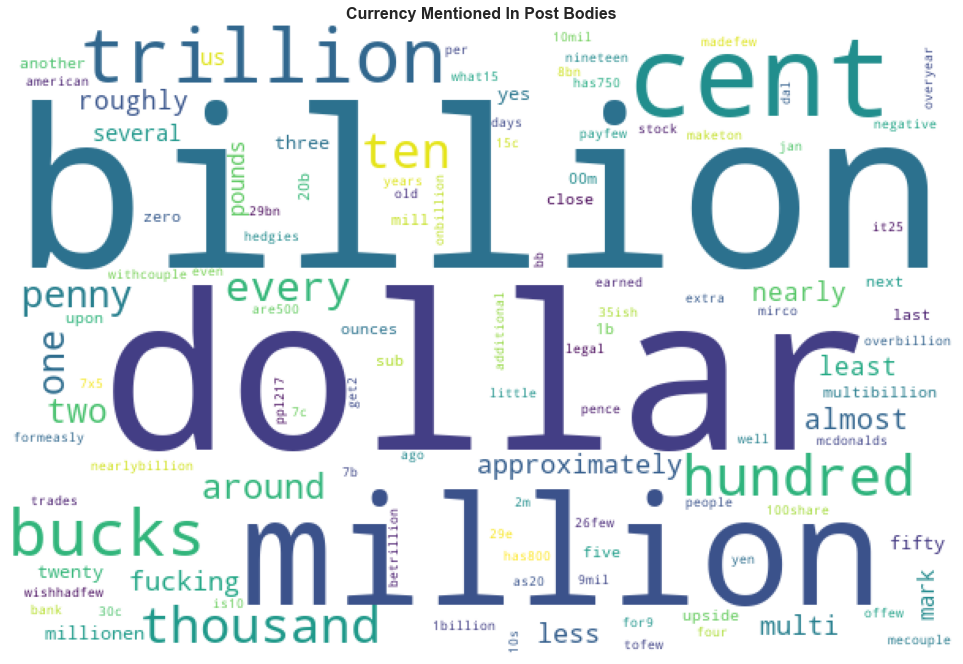

In [33]:
had_org = body_data[body_data['# Of Times Currency Was Mentioned']>0].copy()
org_names = []
for body in had_org.body:
    org_names+=[str(tok) for tok in nlps(body).ents if tok.label_ == 'MONEY' ]
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(' '.join(org_names))

plt.title('Currency Mentioned In Post Bodies',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()    

<a name="EDA"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:black; border:0' role="tab" aria-controls="home"><center>Conclusion</center></h3>


Based on the sentiment analysis done, we learned that
+ The dominant sentiment of WallStreetBets posts is **neutral**.
+ It seems that the sentiments of the posts body contains 2 underlying groups, it can be interesting to further explore those groups and understand their attributes.
+ The sentiments of both bodies and titles is not stationary over our timeline and it seems there is an incline in the positivity of the posts.
+ The **82%** of the variance in the text of WallStreet realated posts can be explained only 450 words.
+ There are slight correlations between naive text features such as number of stops words and the overal number of words to the sentiment of the text.
+ There is a declining trend in the titles negative sentiments, it seems that the titles slowley become more positive.